Author - Priyanka Vasanthakumari

# Tabular Methods

In this assignment, you will solve the FrozenLake-v0 environment from OpenAI gym using 
* Tabular Q learning 

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.The surface is described using a grid like the following 

        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

source: https://gym.openai.com/envs/FrozenLake-v0/  

## The Environment Parameters
* Use discount factor, $\gamma = 0.9$
* The environment is slippery, ie., the transition kernel is stochastic
* The environment consists of 16 states. (env.nS: count of state (int))
* The agent can take 4 actions (env.nA: count of action (int))
* The transition kernel P is a dictionary. 
* P[state][action] is tuples with (probability, nextstate, reward, terminal)
* **Use the following code snippet to set up the gym environemnt for all the questions**

In [ ]:
import gym
from gym.envs.registration import register
register(
    id='D4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': True})
env = gym.make('D4x4-FrozenLake-v0')
gamma = 0.9

In [ ]:
#Obtaining environment details 
print('Number of Actions', env.nA) 
print('Number of States ', env.nS)
print('P[10,3]', env.P[10][2][0])
P = env.P[10][3]
len(P)

Number of Actions 4
Number of States  16
P[10,3] (0.3333333333333333, 14, 0.0, False)


3

## Generating a Heatmap 


In [ ]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
def fancy_visual(value_func,policy_int):    
    grid = 4    
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap="icefire",vmax=1.1, robust = True,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of Q-learning with value function values and directions')
    plt.show()



# Q Learning 
* Q learning is a model free approach, thus you will not use the transition kernel. 
* You can reset the environment using env.reset()
* env.step(action) takes in action as an argument and gives next state,reward,terminal and info as the output 

Q-values
[[0.05755927 0.0592396  0.05763527 0.05345166]
 [0.03461133 0.04263261 0.03432504 0.05385011]
 [0.06465014 0.0638519  0.06124763 0.05287989]
 [0.03420502 0.03638399 0.02581687 0.05293932]
 [0.07882407 0.06069597 0.05754008 0.04369994]
 [0.         0.         0.         0.        ]
 [0.08114024 0.09292908 0.08958589 0.01728079]
 [0.         0.         0.         0.        ]
 [0.06925666 0.10864869 0.09331766 0.1295716 ]
 [0.138242   0.23189862 0.19582221 0.13168206]
 [0.31105485 0.22594705 0.21445264 0.10865158]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.17143174 0.26231022 0.34645305 0.27518199]
 [0.36687642 0.66278718 0.5543202  0.53978812]
 [0.         0.         0.         0.        ]]
Values
[0.0592396  0.05385011 0.06465014 0.05293932 0.07882407 0.
 0.09292908 0.         0.1295716  0.23189862 0.31105485 0.
 0.         0.34645305 0.66278718 0.        ]
Policy
[1 3 0 3 0 0 1 0 3 1 0 0 0 2 1 0]


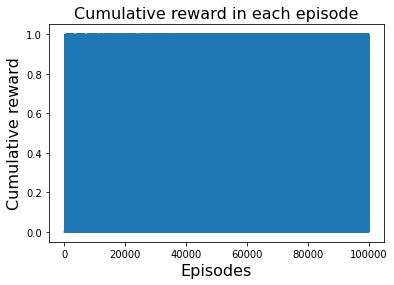

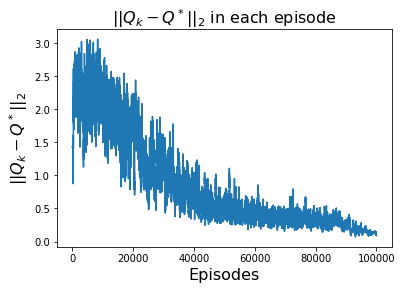

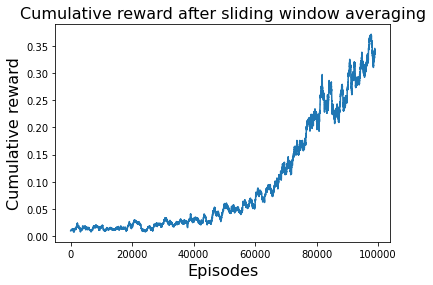

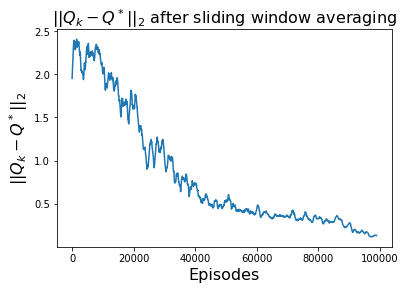

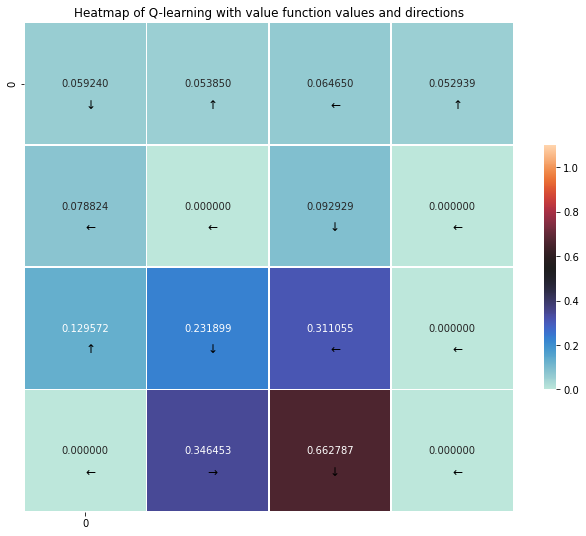

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import convolve

episodes = 100000
gamma = 0.9
state = env.reset() #Reset the env
max_step = 200 
decay = []
q_star = np.array([[0.06848032, 0.0662778,  0.0662778,  0.05935401],
 [0.03886042, 0.04279935, 0.04057157, 0.06111567],
 [0.07422254,0.06863625, 0.0725568,  0.05725891],
 [0.03893572, 0.03893572, 0.03333793, 0.05560469],
 [0.09153995, 0.07099585, 0.06409732, 0.04798672],
 [0.        , 0.         ,0.         ,0.        ],
 [0.11212558, 0.08985882, 0.11212558, 0.02226676],
 [0.         ,0.         ,0.        , 0.        ],
 [0.07101521, 0.11775952, 0.10166828, 0.14522151],
 [0.15751981, 0.24737863, 0.20381218, 0.13342527],
 [0.29954442, 0.26590675, 0.22533083, 0.10785126],
 [0.        , 0.        , 0.        , 0.        ],
 [0.        , 0.        , 0.        , 0.        ],
 [0.18816695, 0.30564652, 0.37986011, 0.26590675],
 [0.39551452, 0.63898452, 0.61488982, 0.53715469],
 [0.        , 0.        , 0.        , 0.        ]]   )                                 # Qstar from value iteration

## Epsilon decay (Piece-wise linear) ##
epsilon = np.zeros(episodes)
epsilon[0:10000] = 1                             # Random exploration
epsilon[10000:80000] = np.linspace(1,0.1, 70000)   # Linear decay
epsilon[80000:100000] = 0.1                       # Constant epsilon

## Learning rate decay ##
alpha = np.linspace(1, 0.01, 100000) # Linear decay

## Function for sliding window average ##
def slidingaverage (data, window):
    weight = np.repeat(1.0, window)/window
    value_avg = np.convolve(data, weight, 'valid')
    return value_avg

## Q-Learning ##
q = np.zeros((env.nS,env.nA))
reward_c = np.zeros(episodes)   # Cumulative reward
for i in range(episodes):
  state = env.reset()
  for step in range (max_step):
    ## Choose action##
    if np.random.uniform(0, 1) < epsilon[i]:
      action = env.action_space.sample() #Random Action - Exploration
    else:
      action = np.argmax(q[state, :])  # Exploitation
    n_state,reward,terminal,_ = env.step(action) #Take a step 
    reward_c[i] += reward
    #Update q-value
    q[state, action] = q[state, action] + alpha[i] * (reward + gamma * np.max(q[n_state,:]) - q[state, action])
    state = n_state
    if terminal:
      break
  decay.append(np.linalg.norm(q-q_star, ord=2))
print ("Q-values")
print(q)
stateValues = np.max(q, axis=1)
print("Values")
print(stateValues)
policy=np.argmax(q,axis =1)
print("Policy")
print(policy)

#Plot cumulative reward
plt.figure(2)
plt.plot(reward_c)   
plt.ylabel("Cumulative reward",fontsize=16)
plt.xlabel("Episodes",fontsize=16)  
plt.title('Cumulative reward in each episode', fontsize = 16)            

## Plot (Qk-Q*) ##
plt.figure(3)
plt.plot(decay)
plt.xlabel('Episodes',fontsize=16)
plt.ylabel('$||Q_{k} - Q^*||_2$',fontsize=16)
plt.title('$||Q_{k} - Q^*||_2$ in each episode', fontsize = 16)            


## Sliding average plots ##
reward_avg = slidingaverage(reward_c,1000)
plt.figure(4)
plt.plot(reward_avg)   
plt.ylabel("Cumulative reward",fontsize=16)
plt.xlabel("Episodes",fontsize=16)
plt.title('Cumulative reward after sliding window averaging', fontsize = 16)            

decay_avg = slidingaverage(decay,1000)
plt.figure(5)
plt.plot(decay_avg)   
plt.ylabel("$||Q_{k} - Q^*||_2$",fontsize=16)
plt.xlabel("Episodes",fontsize=16)
plt.title('$||Q_{k} - Q^*||_2$ after sliding window averaging', fontsize = 16) 

# Heat map
fancy_visual(stateValues,policy)


